**Politicall Bias Detection with DistillBert + Stacked LSTM**

The following code was used to generate the poltical bias detection model. This was ran on Google Colab, so do not expect it to run on the local machine.

In [ ]:
!pip install nltk
!pip install tensorflow
!pip install tensorflow_text
!pip install sklearn
!pip install sentencepiece
!pip install tf-sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 40.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.6 MB/s eta 0:00:00


In [ ]:
!python --version

Python 3.10.12


In [ ]:
# Use GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())
print(tf.__version__)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8872078293223384566
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14357954560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1438954624679040747
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
2.13.0


In [ ]:
import tensorflow_text as t

t.__version__

'2.13.0'

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
df = pd.read_csv("drive/My Drive/data_v1.csv") # GET EXTRACTED IBC

df.dropna(inplace=True)
label_mapping = {"left": 0, "center": 1, "right": 2}
df.bias_text = df.bias_text.map(label_mapping)
df.head()

Mounted at /content/drive


,Unnamed: 0,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,0,terrorism,New York Times - News,0,http://www.nytimes.com/2016/09/20/nyregion/ahm...,"Bomb Suspect Changed After Trip Abroad, Friend...",2016-09-20,N. R. Kleinfield,"Besides his most recent trip to Quetta , Mr. R...","Besides his most recent trip to Quetta, Mr. Ra...",www.nytimes.com,0,004Gt3gcsotuiYmz
1,1,supreme_court,Vox,0,https://www.vox.com/policy-and-politics/2018/9...,Why Susan Collins claims she’s being bribed ov...,2018-09-12,"Emily Stewart, Terry Nguyen, Rebecca Jennings,...",Is Maine Republican Sen. Susan Collins being b...,Is Maine Republican Sen. Susan Collins being b...,www.vox.com,0,00eP4XD3VdMmHITE
2,2,education,Ezra Klein,0,http://www.npr.org/blogs/thetwo-way/2014/05/06...,Poll: Prestigious Colleges Won't Make You Happ...,2014-05-06,Anya Kamenetz,Poll : Prestigious Colleges Wo n't Make You Ha...,Poll: Prestigious Colleges Won't Make You Happ...,www.npr.org,0,00FTGIZEd6B8zQ4U
3,3,us_house,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Paul Ryan Reportedly Says No Chance for Border...,2017-09-12,Ian Mason,"House Speaker Paul Ryan , at a private dinner ...","House Speaker Paul Ryan, at a private dinner e...",www.breitbart.com,2,00HGGqBRf1kzPRlg
4,4,white_house,Guest Writer - Left,0,https://www.cnn.com/2019/07/11/politics/donald...,OPINION: Trump seeking change of legal fortune...,2019-07-11,Analysis Stephen Collinson,( CNN ) President Donald Trump has reason to h...,(CNN) President Donald Trump has reason to hop...,www.cnn.com,0,00IzI5ynahBVtC9l


In [ ]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

import re
df["content_original"] = df["content_original"].apply(lambda x: x.lower())
df['content_original'] = df['content_original'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))
df["content_original"] = df["content_original"].apply(lambda x: remove_stopwords(x))

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Unnamed: 0,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,0,terrorism,New York Times - News,0,http://www.nytimes.com/2016/09/20/nyregion/ahm...,"Bomb Suspect Changed After Trip Abroad, Friend...",2016-09-20,N. R. Kleinfield,"Besides his most recent trip to Quetta , Mr. R...",besides recent trip quetta mr rahami visited k...,www.nytimes.com,0,004Gt3gcsotuiYmz
1,1,supreme_court,Vox,0,https://www.vox.com/policy-and-politics/2018/9...,Why Susan Collins claims she’s being bribed ov...,2018-09-12,"Emily Stewart, Terry Nguyen, Rebecca Jennings,...",Is Maine Republican Sen. Susan Collins being b...,maine republican sen susan collins bribed vote...,www.vox.com,0,00eP4XD3VdMmHITE
2,2,education,Ezra Klein,0,http://www.npr.org/blogs/thetwo-way/2014/05/06...,Poll: Prestigious Colleges Won't Make You Happ...,2014-05-06,Anya Kamenetz,Poll : Prestigious Colleges Wo n't Make You Ha...,poll prestigious colleges make happier life wo...,www.npr.org,0,00FTGIZEd6B8zQ4U
3,3,us_house,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Paul Ryan Reportedly Says No Chance for Border...,2017-09-12,Ian Mason,"House Speaker Paul Ryan , at a private dinner ...",house speaker paul ryan private dinner earlier...,www.breitbart.com,2,00HGGqBRf1kzPRlg
4,4,white_house,Guest Writer - Left,0,https://www.cnn.com/2019/07/11/politics/donald...,OPINION: Trump seeking change of legal fortune...,2019-07-11,Analysis Stephen Collinson,( CNN ) President Donald Trump has reason to h...,cnn president donald trump reason hope luck ch...,www.cnn.com,0,00IzI5ynahBVtC9l


0    10291
2     9055
1     5836
Name: bias_text, dtype: int64


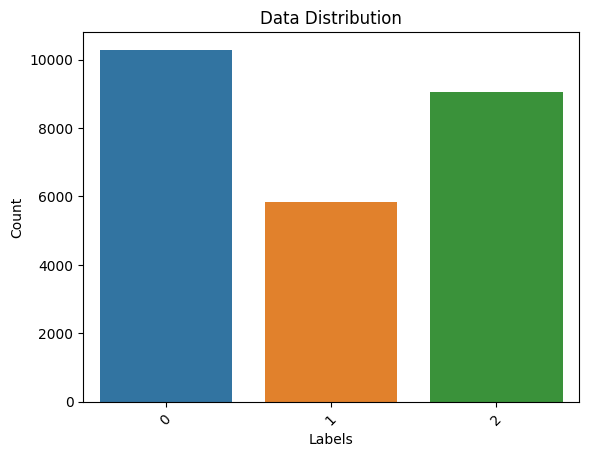

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

label_counts = df['bias_text'].value_counts()

print(label_counts)
sns.countplot(x='bias_text', data=df)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Data Distribution')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["content_original"], df["bias_text"], test_size=0.2, random_state=7, stratify=df["bias_text"]) # 90 to 10 split

X_train, y_train

y_train.value_counts()

0    8232
2    7244
1    4669
Name: bias_text, dtype: int64

In [ ]:
import tensorflow as tf
# loading arrays into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


# using map method to apply map_func to dataset
train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

train_dataset, test_dataset

(<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, MaxPool1D, Dense, Dropout, LSTM
from tensorflow.keras.regularizers import L1, L2

# define a text embedding model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_multi_cased_preprocess/2")
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1", trainable=False)
ctx_embeddings = encoder(encoder_inputs)["sequence_output"]

# Stacked LSTM
x = LSTM(units=64, return_sequences=True)(ctx_embeddings)
x = LSTM(units=64, return_sequences=False)(x)
x = Dropout(0.2)(x)

# Fully Connected
x = Dense(units=48, activation="relu", kernel_regularizer = L1(l1=0.0001))(x)
x = Dropout(0.1)(x)
outputs = Dense(units=3, activation="softmax")(x)

model = tf.keras.Model(text_input, outputs=outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                    
                                                                                                  
 keras_layer_1 (KerasLayer)  {'encoder_outputs': [(None   1347340   ['keras_layer[0][0]',     

In [ ]:
optimizer = tf.keras.optimizers.experimental.Adam(0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
acc = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath="drive/My Drive/model.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
history = model.fit(train_dataset, validation_data=test_dataset, callbacks=[save_best, early_stop], epochs=50)

Epoch 1/50
2519/2519 [==============================] - 280s 105ms/step - loss: 1.0879 - accuracy: 0.4172 - val_loss: 1.0249 - val_accuracy: 0.4910
Epoch 2/50
2519/2519 [==============================] - 263s 104ms/step - loss: 0.9473 - accuracy: 0.5382 - val_loss: 0.8446 - val_accuracy: 0.6162
Epoch 3/50
2519/2519 [==============================] - 305s 121ms/step - loss: 0.7936 - accuracy: 0.6325 - val_loss: 0.7266 - val_accuracy: 0.6633
Epoch 4/50
2519/2519 [==============================] - 269s 107ms/step - loss: 0.6764 - accuracy: 0.6951 - val_loss: 0.6826 - val_accuracy: 0.6962
Epoch 5/50
2519/2519 [==============================] - 261s 104ms/step - loss: 0.6289 - accuracy: 0.7256 - val_loss: 0.6891 - val_accuracy: 0.6873
Epoch 6/50
2519/2519 [==============================] - 260s 103ms/step - loss: 0.5876 - accuracy: 0.7508 - val_loss: 0.6912 - val_accuracy: 0.6957
Epoch 7/50
2519/2519 [==============================] - 266s 106ms/step - loss: 0.5328 - accuracy: 0.7852 - val_

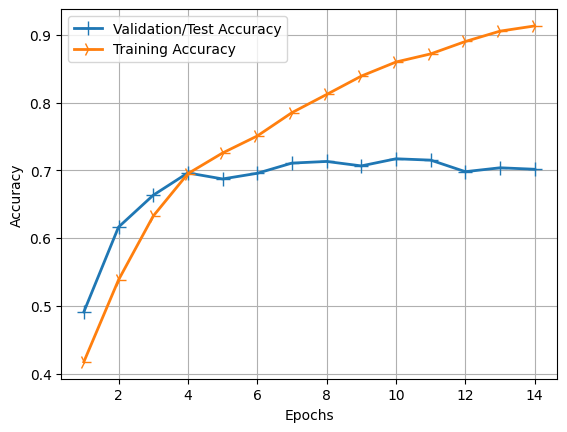

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

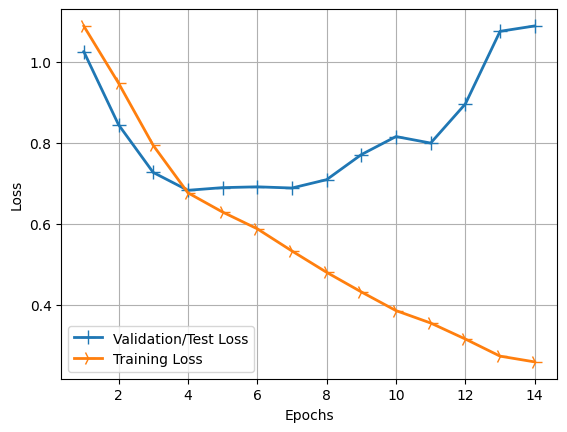

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import numpy as np

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test
y_pred

158/158 [==============================] - 44s 266ms/step


array([1, 2, 2, ..., 2, 0, 1])

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm

array([[1242,  186,  631],
       [ 107,  833,  227],
       [ 189,  163, 1459]])

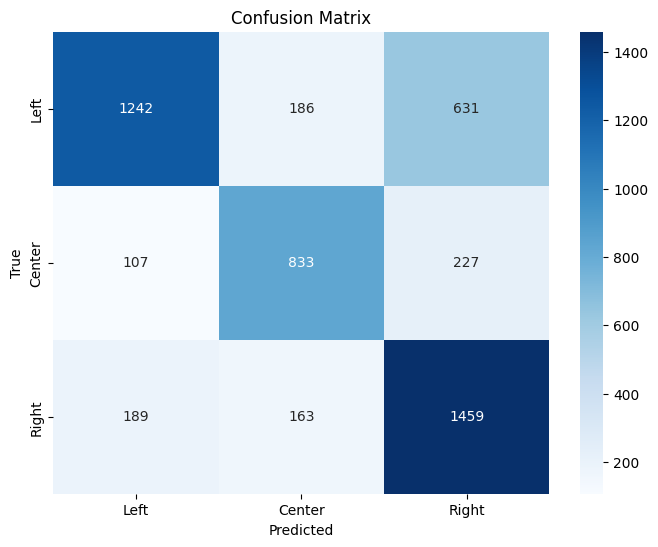

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels (change these to your specific class names)
class_labels = ["Left", "Center", "Right"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save("drive/My Drive/LSTM_MODEL.h5")